In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [2]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)



Число обусловленности такой матрицы будет большим

In [3]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.0426485843, 406095.04267807666)

In [4]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [9]:
def ConjugateGradient(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0)
    p = r
    while np.linalg.norm(r) > tol:
        
        #TO DO
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        #END TO DO
        if callback is not None:
            callback(x)
    return x

In [10]:
def PreconditionedCG(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    z = sp.linalg.spsolve(M, r)
    p = z
    w = A @ p.T
    a = r.dot(z) / p.dot(w)
    x = x + a * p
    r1 = r - a * w
    while np.linalg.norm(r) > tol:
        
        #TO DO
        z1 = sp.linalg.spsolve(M, r1)
        beta = r1.dot(z1) / r.dot(z)
        p = z1 + beta * p
        w = A @ p
        a = r1.dot(z1) / p.dot(w)
        x = x + a * p
        r1, r = r1 - a * w, r1
        z = z1
        #END TO DO
        if callback is not None:
            callback(x)
    return x

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [11]:
D = sp.diags(A.diagonal(), shape=A.shape)
DI = sp.diags(1 / A.diagonal(), shape=A.shape)
L = sp.tril(A)
U = sp.triu(A)
M = (D + L) @ (DI) @ (D + U)

Сравните результат работы предобусловленной и непредобусловленной версии

In [12]:
xk_array = []
callback = lambda x: xk_array.append(x)

ConjugateGradient(x0, A, b, callback=callback)
cg = xk_array
xk_array = []

PreconditionedCG(x0, A, b, callback=callback)
pcg = xk_array

print(len(cg), len(pcg))

1001 642


Как видим, предобусловленный метод сходится быстрее.

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [31]:
import types
def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

#Callback и в  GD и в CG написан по убогому, поэтому этот костыль для рисования графика
def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

In [148]:
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

  
    while True:

        beta2 = 1. -beta1
        #TO DO
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [149]:
def MomentumGD(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3, mu=0.9):
    x = x0.copy()
    iteration = 0
    conv_array = []

    V = 0
    while True:

        beta2 = 1. -beta1
        #TO DO
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        V = mu * V - alpha * gradient
        x = x + V
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [150]:
def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        #TO DO
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        #END TO DO
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [151]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)

# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

In [160]:
res_nest = NesterovAcceleratedGD(f, grad_f, x0, momentum=0.15)
x_na, y_na = get_x_y_from_callback(res_nest["conv_array"], x0)
res = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
x_gd, y_gd = get_x_y_from_callback(res['conv_array'], x0)

res_mom = MomentumGD(f, grad_f, x0, rho=0.5, beta1=0.2, mu=0.15)
x_mom, y_mom = get_x_y_from_callback(res_mom['conv_array'], x0)

print(len(x_na), len(x_gd), len(x_mom))

31 70 46


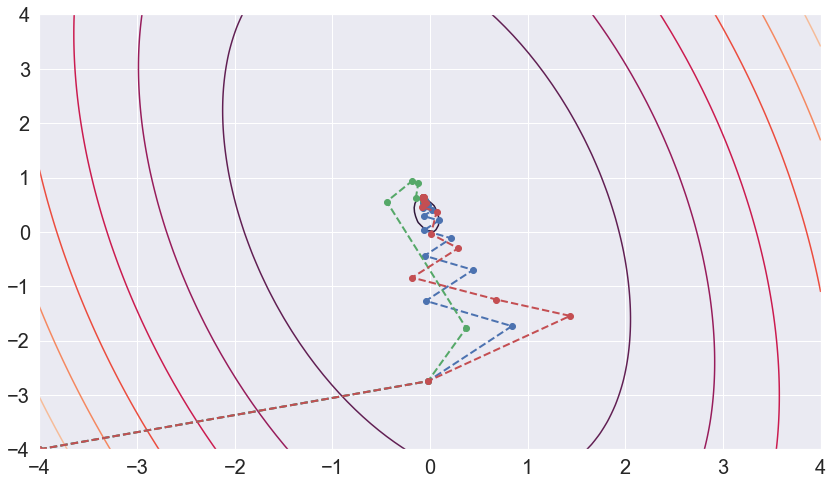

In [161]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.contour(x, y, f_x)
plt.plot(x_gd, y_gd, '--bo',linewidth=2, label=' Gradient Descent')
plt.plot(x_na, y_na ,'--go', linewidth=2, label='NA Gradient Descent')
plt.plot(x_mom, y_mom ,'--ro', linewidth=2, label='Momentum Gradient Descent')


На скорость сходимости влияет параметр mu. В целом, метод момента сходится быстрее обычного градиентного спуска, но медленнее метода Нестерова.